In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import pints
import pints.plot
import pystreamflow

# pystreamflow example notebook

This notebook demonstrates the model and data in the pystreamflow package.

The package includes river data for the French Broad River at Asheville, North Carolina (USGS station 03451500).

This data can be loaded using the `load_data` function in pystreamflow, which returns a pandas dataframe.

In [2]:
data = pystreamflow.load_data('03451500')
print(data.head(10))

   year  month  day  precipitation  evaporation  streamflow  max_temp  \
0  1960      1    1           0.00        0.670      1.8907    1.7667   
1  1960      1    2          14.53        0.680      1.8210    6.0778   
2  1960      1    3           7.51        0.683      2.7863    9.3833   
3  1960      1    4           0.29        0.687      3.2540    4.5056   
4  1960      1    5          17.23        0.692      2.6072    3.9889   
5  1960      1    6           7.68        0.697      3.3535    4.3167   
6  1960      1    7           4.03        0.702      3.4331    7.3889   
7  1960      1    8           0.01        0.708      3.0450   10.9000   
8  1960      1    9           0.00        0.714      2.6868   14.6222   
9  1960      1   10           0.01        0.721      2.4479   16.2944   

   min_temp  
0   -7.2500  
1   -3.1667  
2    0.2667  
3   -3.6389  
4   -1.3778  
5   -0.5667  
6    0.8500  
7   -2.6556  
8   -4.7111  
9   -0.8389  


As seen above, the file contains columns for the year, month, day, precipitation, evaporation, streamflow, maximum temperature, and minimum temperature. Precipitation and evaporation are measured for the river basin. The temperatures are not needed for the model that will be studied in this notebook.

We will next extract a 200 day period of the data for analysis.

In [3]:
precip = data['precipitation'].to_numpy()[365:566]
evap = data['evaporation'].to_numpy()[365:566]
flow = data['streamflow'].to_numpy()[365:566]
all_times = np.arange(len(precip))

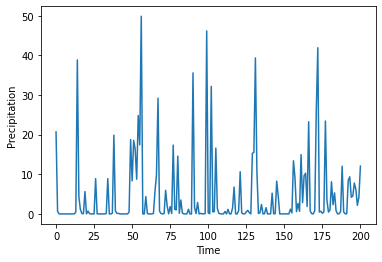

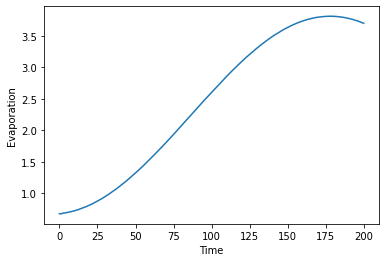

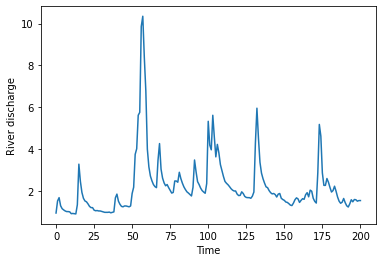

In [4]:
plt.plot(all_times, precip)
plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.show()

plt.plot(all_times, evap)
plt.xlabel('Time')
plt.ylabel('Evaporation')
plt.show()

plt.plot(all_times, flow)
plt.xlabel('Time')
plt.ylabel('River discharge')
plt.show()

The two model inputs (precipitation and evaporation) and the model output (river discharge) are shown in the plots above. The river discharge tends to increase following rainfall. This behavior depends on the flow of water through the river basin, and it is modelled by the `pystreamflow.RiverModel` object.

This model has four latent state variables, each representing the level of water in various hydrological processes in the river basin:

- $S_i$ (interception storage—capture of water by vegetation)
- $S_u$ (unsaturated storage—soil above the water table)
- $S_s$ (slow reservoir)
- $S_f$ (fast reservoir)

Additionally, the observed variable is the river discharge $dz/dt$.

The system of differential equations describing the flow of water over time is:

- $dS_i/dt = \text{Precip}(t) - \text{InterceptEvap}(t) - \text{EffectPrecip}(t)$
- $dS_u/dt = \text{EffectPrecip}(t) - \text{UnsatEvap}(t) - \text{Percolation}(t) - \text{Runoff}(t)$
- $dS_s/dt = \text{Percolation}(t) - \text{SlowStream}(t)$
- $dS_f/dt = \text{Runoff}(t) - \text{FastStream}(t)$
- $dz/dt = \text{SlowStream}(t) + \text{FastStream}(t)$

Each of the named terms in the equations above is defined below in terms of the seven unknown model parameters:

- $I_\text{max}$ = maximum interception
- $S_\text{u,max}$ = unsaturated storage capacity
- $Q_\text{s,max}$ = maximum percolation
- $\alpha_e$ = evaporation flux shape
- $\alpha_f$ = runoff flux shape
- $K_s$ = slow reservoir time constant
- $K_f$ = fast reservoir time constant

and the following two parameters which have fixed values in this version of the model:

- $\alpha_s$ = 0 (percolation flux shape)
- $\alpha_i$ = 50 (interception flux shape)

Many of the terms depend on a nonlinear flux function $f$, which is given by

$$f(S, a) = (1 - exp(-a S)) / (1 - exp(-a))$$

- Precip = measured precipitation (provided as input to the model)
- Evap = measured or theoretical evaporation (provided as input to the model)
- InterceptEvap = evaporation from the interception component
   - $\text{InterceptEvap}(t) = \text{Evap}(t) * f(S_i / I_\text{max}, \alpha_i)$
- EffectPrecip = effective precipitation that gets sent to unsaturated
    storage
    - $\text{EffectPrecip}(t) = \text{Precip}(t) * f(S_i / I_\text{max}, -\alpha_i)$
- UnsatEvap = evaporation from unsaturated storage
    - $\text{UnsatEvap}(t) = \text{max}(0, \text{Evap}(t) - \text{InterceptEvap}(t))
                       * f(S_u / S_\text{u,max}, \alpha_e)$
- Percolation = trickling of water through the ground
    - $\text{Percolation}(t) = Q_\text{s,max} * f(S_u / S_\text{u,max}, \alpha_s)$
- Runoff = flow of water on the surface
    - $\text{Runoff}(t) = \text{EffectPrecip}(t) * f(S_u / S_\text{u,max}, \alpha_f)$
- SlowStream = The slow component of the river flow
    - $\text{SlowStream}(t) = S_s / K_s$
- FastStream = The fast component of the river flow
    - $\text{FastStream}(t) = S_f / K_f$
    
This model was studied in the following paper:

Schoups, G., & Vrugt, J. A. (2010). A formal likelihood function for parameter and predictive inference of hydrologic models with correlated, heteroscedastic, and non‐Gaussian errors. _Water Resources Research_, 46(10).

The initial levels of water in $S_i, S_u, S_s, S_f$ are unknown. These values could be treated as unknown variables and added to the inference problem, but this increases the dimensionality and makes inference more challenging. Thus, the accepted practice is to set all initial values to some low value (assuming the river basin is completely dry), and then run the simulation for some time with precipitation and evaporation available before comparing its output to discharge data. In this notebook, we will use a 100 day "warm up" period. Thus, the discharge data we supply to the model will begin at day 100, while the precipitation and evaporation data will start at day 0.

In [5]:
data_times = all_times[100:200]
data_flow = flow[100:200]

Evaluations of the RiverModel involve the integration of a system of differential equations. If these equations are not solved with sufficient accuracy, the likelihood surface will be exhibit jaggedness, and MCMC will produce a poor estimate of the parameter posterior.

pystreamflow provides two solver options, `scipy` and `scikit` (cvode), and allows the user to select the relative tolerance and absolute tolerance for the solve. The following figure shows how too large values of rtol and atol will cause problems for inference. In this case, the default settings result in an acceptable likelihood surface.

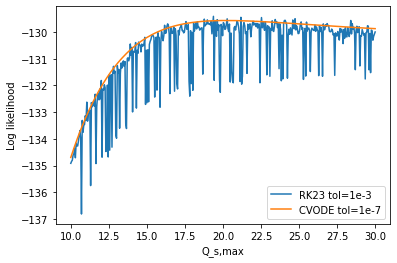

In [14]:
m = pystreamflow.RiverModel(
    all_times, precip, evap, solver='scipy', rtol=1e-3, atol=1e-3)

m_accurate = pystreamflow.RiverModel(
    all_times, precip, evap, solver='scikit')

problem = pints.SingleOutputProblem(m, data_times, data_flow)
likelihood = pints.GaussianLogLikelihood(problem)

problem_accurate = pints.SingleOutputProblem(
    m_accurate, data_times, data_flow)
likelihood_accurate = pints.GaussianLogLikelihood(problem_accurate)

params = [9.0, 800.0, 20.0, 80.0, 0.2, 70.0, 2.0, 1.0]

q_range = np.linspace(10.0, 30.0, 400)
lls = []
lls_accurate = []
for q in q_range:
    params[2] = q
    lls.append(likelihood(params))
    lls_accurate.append(likelihood_accurate(params))

plt.plot(q_range, lls, label='RK23 tol=1e-3')
plt.plot(q_range, lls_accurate, label='CVODE tol=1e-7')
plt.legend()
plt.xlabel('Q_s,max')
plt.ylabel('Log likelihood')
plt.show()

The next step is to build the prior and likelihood used by PINTS.

In [6]:
# Model
m = pystreamflow.RiverModel(all_times, precip, evap, solver='scikit')

# Prior for each parameter
I_max_prior = pints.UniformLogPrior(0, 10)
S_umax_prior = pints.UniformLogPrior(10, 1000)
Q_smax_prior = pints.UniformLogPrior(0, 100)
alpha_e_prior = pints.UniformLogPrior(0, 100)
alpha_f_prior = pints.UniformLogPrior(-10, 10)
K_s_prior = pints.UniformLogPrior(0, 150)
K_f_prior = pints.UniformLogPrior(0, 10)
sigma_prior = pints.UniformLogPrior(0, 10)

# Make posterior for pints
problem = pints.SingleOutputProblem(m, data_times, data_flow)
likelihood = pints.GaussianLogLikelihood(problem)
prior = pints.ComposedLogPrior(
    I_max_prior,
    S_umax_prior,
    Q_smax_prior,
    alpha_e_prior,
    alpha_f_prior,
    K_s_prior,
    K_f_prior,
    sigma_prior
)
posterior = pints.LogPosterior(likelihood, prior)

We can then use MCMC to infer the posterior distribution of the model parameters.

In [7]:
transform = pints.RectangularBoundariesTransformation([0, 10, 0, 0, -10, 0, 0, 0],
                                                      [10, 1000, 100, 100, 10, 150, 10, 10])

num_iterations = 25000
mcmc = pints.MCMCController(
posterior, 6, prior.sample(6), method=pints.DreamMCMC, transform=transform)
mcmc.set_max_iterations(num_iterations)
mcmc.set_parallel(True)
chains = mcmc.run()

Using DiffeRential Evolution Adaptive Metropolis (DREAM) MCMC
Generating 6 chains.
Running in parallel with 6 worker processess.
Iter. Eval.  Time m:s
0     6        0:00.4
1     12       0:00.7
2     18       0:00.9
3     24       0:01.2
20    126      0:06.9
40    246      0:13.0
60    366      0:19.0
80    486      0:25.2
100   606      0:31.1
120   726      0:37.0
140   846      0:42.7
160   966      0:48.0
180   1086     0:53.3
Initial phase completed.
200   1206     0:58.6
220   1326     1:04.2
240   1446     1:09.9
260   1566     1:15.2
280   1686     1:20.5
300   1806     1:26.2
320   1926     1:31.3
340   2046     1:36.7
360   2166     1:42.2
380   2286     1:47.5
400   2406     1:53.2
420   2526     1:58.7
440   2646     2:03.8
460   2766     2:08.7
480   2886     2:13.2
500   3006     2:18.3
520   3126     2:23.1
540   3246     2:28.1
560   3366     2:32.9
580   3486     2:37.7
600   3606     2:42.6
620   3726     2:47.4
640   3846     2:52.0
660   3966     2:56.8
680   4086

7240  43446   29:19.2
7260  43566   29:24.8
7280  43686   29:30.7
7300  43806   29:36.4
7320  43926   29:42.0
7340  44046   29:47.6
7360  44166   29:53.2
7380  44286   29:58.7
7400  44406   30:04.4
7420  44526   30:10.1
7440  44646   30:16.0
7460  44766   30:21.7
7480  44886   30:27.5
7500  45006   30:33.4
7520  45126   30:39.0
7540  45246   30:44.4
7560  45366   30:50.0
7580  45486   30:55.7
7600  45606   31:01.2
7620  45726   31:06.7
7640  45846   31:12.2
7660  45966   31:17.7
7680  46086   31:23.2
7700  46206   31:28.7
7720  46326   31:34.5
7740  46446   31:40.3
7760  46566   31:46.0
7780  46686   31:51.8
7800  46806   31:57.6
7820  46926   32:03.4
7840  47046   32:09.0
7860  47166   32:14.7
7880  47286   32:20.4
7900  47406   32:26.3
7920  47526   32:32.1
7940  47646   32:37.9
7960  47766   32:43.8
7980  47886   32:49.8
8000  48006   32:55.4
8020  48126   33:00.9
8040  48246   33:06.4
8060  48366   33:12.0
8080  48486   33:17.5
8100  48606   33:23.0
8120  48726   33:28.6
8140  4884

14700 88206   64:18.4
14720 88326   64:24.1
14740 88446   64:29.9
14760 88566   64:35.6
14780 88686   64:41.2
14800 88806   64:46.9
14820 88926   64:52.5
14840 89046   64:58.1
14860 89166   65:03.6
14880 89286   65:09.4
14900 89406   65:15.3
14920 89526   65:21.0
14940 89646   65:26.8
14960 89766   65:32.5
14980 89886   65:38.3
15000 90006   65:44.1
15020 90126   65:49.7
15040 90246   65:55.2
15060 90366   66:01.1
15080 90486   66:07.1
15100 90606   66:12.9
15120 90726   66:18.4
15140 90846   66:24.1
15160 90966   66:29.7
15180 91086   66:35.3
15200 91206   66:41.3
15220 91326   66:47.1
15240 91446   66:53.1
15260 91566   66:58.7
15280 91686   67:04.5
15300 91806   67:10.2
15320 91926   67:15.8
15340 92046   67:21.8
15360 92166   67:27.6
15380 92286   67:33.6
15400 92406   67:39.7
15420 92526   67:45.8
15440 92646   67:51.6
15460 92766   67:57.5
15480 92886   68:03.3
15500 93006   68:08.9
15520 93126   68:14.7
15540 93246   68:20.5
15560 93366   68:26.1
15580 93486   68:31.8
15600 9360

22160 132966  98:43.3
22180 133086  98:47.6
22200 133206  98:52.3
22220 133326  98:56.5
22240 133446  99:00.8
22260 133566  99:05.4
22280 133686  99:09.9
22300 133806  99:14.3
22320 133926  99:18.8
22340 134046  99:23.0
22360 134166  99:27.0
22380 134286  99:31.3
22400 134406  99:35.6
22420 134526  99:40.2
22440 134646  99:44.6
22460 134766  99:49.2
22480 134886  99:53.5
22500 135006  99:58.0
22520 135126 100:02.5
22540 135246 100:07.2
22560 135366 100:11.5
22580 135486 100:16.1
22600 135606 100:20.3
22620 135726 100:24.8
22640 135846 100:29.9
22660 135966 100:34.4
22680 136086 100:38.9
22700 136206 100:43.4
22720 136326 100:48.1
22740 136446 100:52.9
22760 136566 100:57.0
22780 136686 101:01.4
22800 136806 101:05.4
22820 136926 101:10.3
22840 137046 101:15.0
22860 137166 101:19.6
22880 137286 101:24.1
22900 137406 101:28.9
22920 137526 101:33.4
22940 137646 101:38.0
22960 137766 101:42.6
22980 137886 101:46.9
23000 138006 101:51.7
23020 138126 101:55.9
23040 138246 102:00.7
23060 1383

We can monitor the MCMC chains using `pints.plot`. Here, we plot the chains as well as the parameter posteriors and model fits.

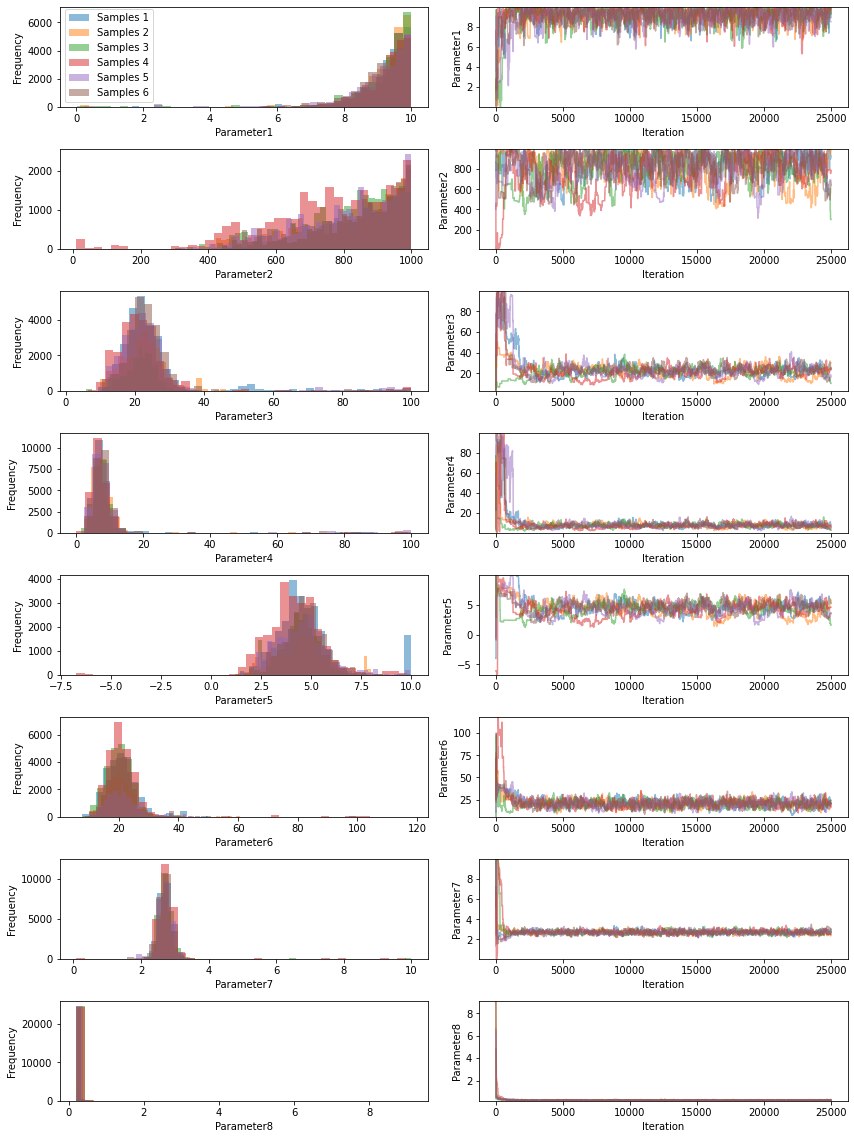

In [8]:
pints.plot.trace(chains)
plt.show()

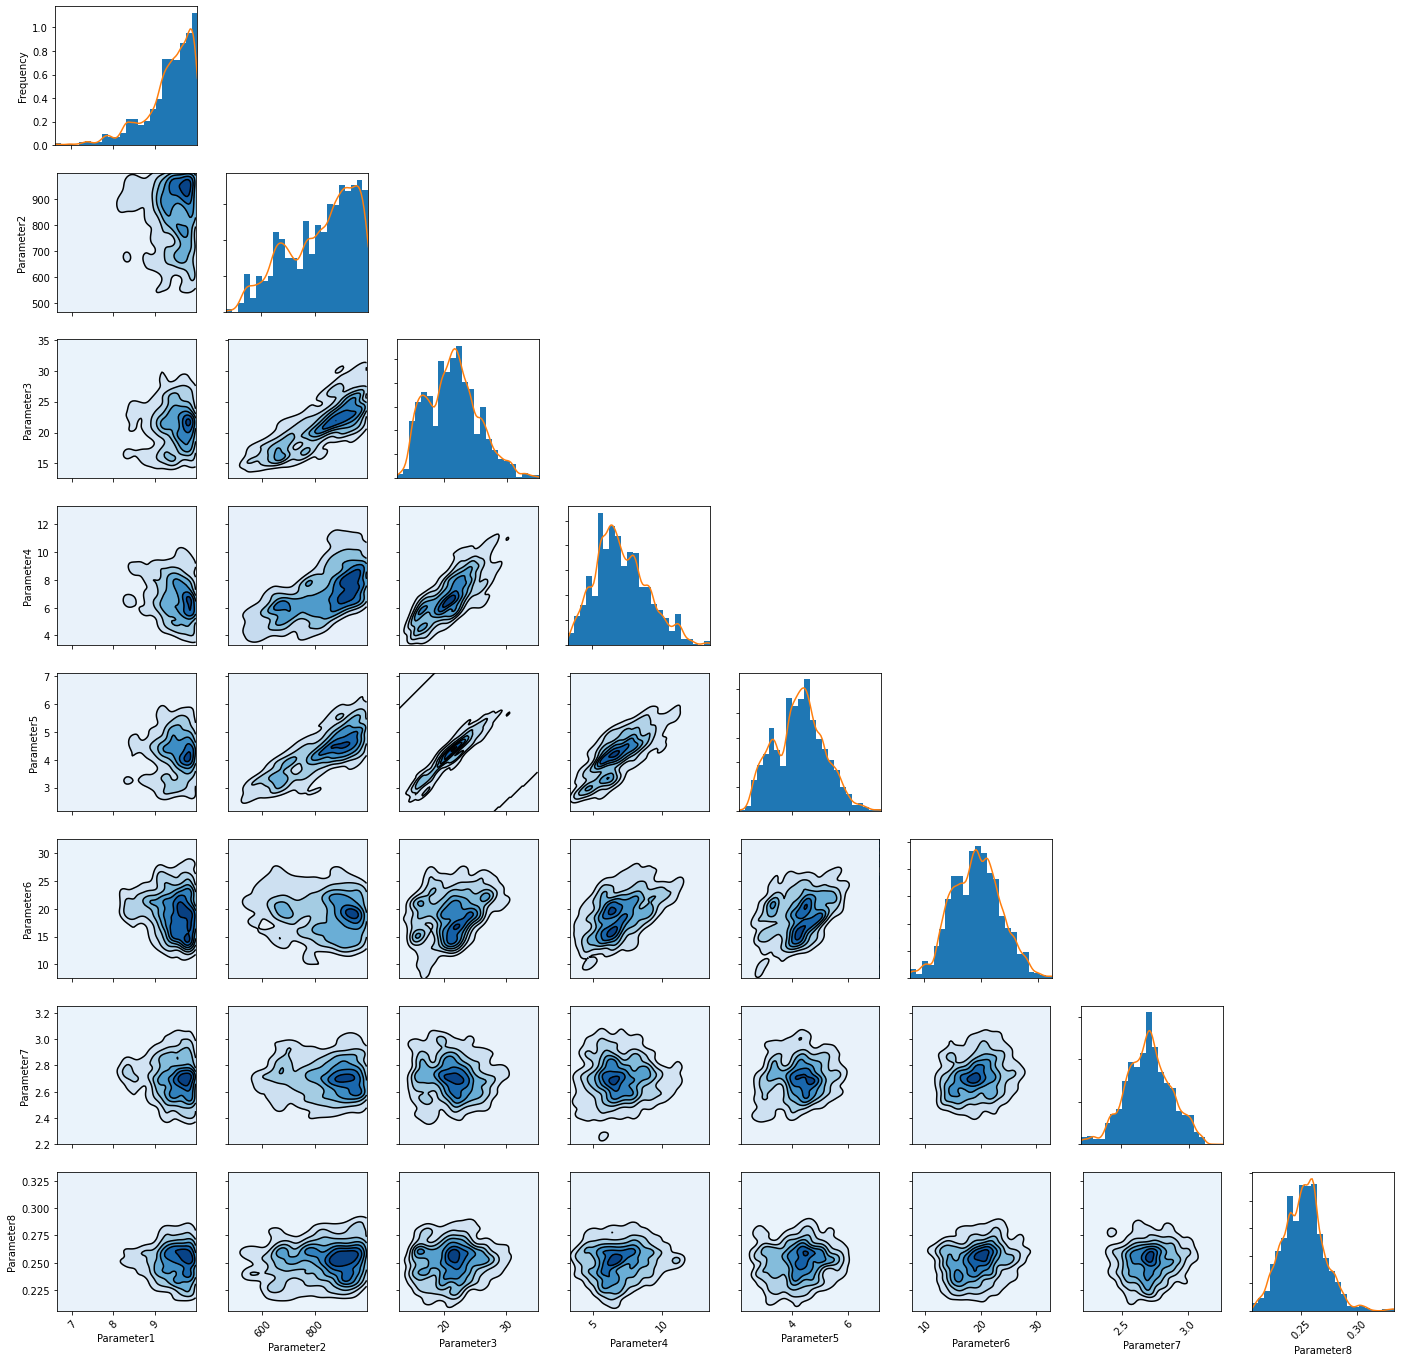

In [9]:
pints.plot.pairwise(chains[0, num_iterations//2:, :], kde=True)
plt.show()

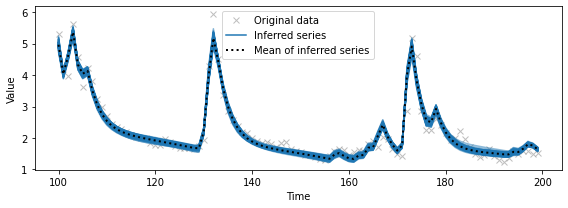

In [10]:
pints.plot.series(chains[0,num_iterations//2:,:], problem, thinning=100)
plt.show()